[INFO] loading images...
[INFO] compiling model...
[INFO] training head...


C:\Users\ASUS\TOD\tfod\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
5/5 [==============================] - 7s 953ms/step - loss: 0.7907 - accuracy: 0.5000 - val_loss: 0.7778 - val_accuracy: 0.4286
Epoch 2/20
5/5 [==============================] - 4s 804ms/step - loss: 0.7748 - accuracy: 0.5746 - val_loss: 0.6882 - val_accuracy: 0.5952
Epoch 3/20
5/5 [==============================] - 4s 770ms/step - loss: 0.6720 - accuracy: 0.6716 - val_loss: 0.6146 - val_accuracy: 0.7143
Epoch 4/20
5/5 [==============================] - 4s 822ms/step - loss: 0.5699 - accuracy: 0.7687 - val_loss: 0.5564 - val_accuracy: 0.8095
Epoch 5/20
5/5 [==============================] - 4s 912ms/step - loss: 0.5063 - accuracy: 0.8806 - val_loss: 0.5072 - val_accuracy: 0.8333
Epoch 6/20
5/5 [==============================] - 4s 782ms/step - loss: 0.4825 - accuracy: 0.8507 - val_loss: 0.4603 - val_accuracy: 0.8810
Epoch 7/20
5/5 [==============================] - 4s 769ms/step - loss: 0.4454 - accuracy: 0.8806 - val_loss: 0.4155 - val_accuracy: 0.9286
Epoch 8/20
5/5 [====

C:\Users\ASUS\TOD\tfod\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


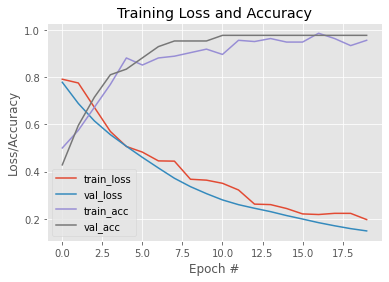

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator      #creates image by changing sizes etc
from tensorflow.keras.applications import MobileNetV2                    #convolutional neural network architecture
from tensorflow.keras.layers import AveragePooling2D                     # takes avg of pixels and reduces the image resolution 
from tensorflow.keras.layers import Dropout                              # helps prevent overfitting
from tensorflow.keras.layers import Flatten                              #to preserve weight ordering when switching from one data format to another data format
from tensorflow.keras.layers import Dense                                #feeds all outputs from the previous layer to all its neurons
from tensorflow.keras.layers import Input                                #instantiate a Keras tensor
from tensorflow.keras.models import Model                                #function with learnable parameters that maps an input to an output
from tensorflow.keras.optimizers import Adam                             # optimization algorithm  ( adam is combination of momentum + RMSprop Algorithms)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  #Preprocesses a tensor or Numpy array encoding a batch of images
from tensorflow.keras.preprocessing.image import img_to_array            # Converts a PIL(Python Imaging Library) Image instance to a Numpy array
from tensorflow.keras.preprocessing.image import load_img                # loading an image from file as a PIL image object
from tensorflow.keras.utils import to_categorical                        # Converts a class vector (integers) to binary class matrix
from sklearn.preprocessing import LabelBinarizer                         # Binarize labels in a one-vs-all fashion
from sklearn.model_selection import train_test_split                     # to split in test and train 
from sklearn.metrics import classification_report                        #  to measure the quality of predictions
from imutils import paths                                                # used for translation, rotation, resizing, skeletonization
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4 
EPOCHS = 20
BS = 32

DIRECTORY = r"D:\Internship\Helmet\dataset"                 # directory of dataset containing folders (with,without Helmet )
CATEGORIES = ["with_helmet", "without_helmet"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")  

data = []            # all images will be appended 
labels = []          # Stores labels 

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)    # join path and category 
    for img in os.listdir(path):                # listdir = lists all images in that directory 
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224)) #load_img = loads img path and target size (height & width of img )
        image = img_to_array(image)                    # img_to_array to convet stored img to array 
        image = preprocess_input(image)     #mobilenets is used here 

        data.append(image)          # append image_array to data list  
        labels.append(category)     # append labels to label list 

# perform one-hot encoding on the labels
lb = LabelBinarizer()               #all data is in numerical value except labels so labelbinarizer is used 
labels = lb.fit_transform(labels)
labels = to_categorical(labels)     # converted to categorical variables 

data = np.array(data, dtype="float32")  # Deep learning arrays only work with arrays
labels = np.array(labels)               # so data & label list is converted to arrays

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=25)    # stratify means classify by labels  
                                                        # Setting random_state a fixed value will guarantee that the same sequence of random
                                                        #numbers is generated each time you run the code

# construct the training image generator for data augmentation
aug = ImageDataGenerator(    #Creates many images by using 1 image by rotating ,shinfting etc
    rotation_range=20,   # rotation angle 
    zoom_range=0.15,     
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")  #will fill the area with the nearest pixel and stretching it.


# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off 
baseModel = MobileNetV2(weights="imagenet", include_top=False,   #imagenet is pretrained model  
                                         # include top is a boolean to connect to layer or not 
    input_tensor=Input(shape=(224, 224, 3)))  # shape of images going trough(H&W as in load_img , 3 channels RGB)


# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel) # reduces the resolution by avging the selected pixels 
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)  # density 128 neurons &activation Funcn Relu 
headModel = Dropout(0.5)(headModel)                  # technique where randomly selected neurons are ignored during training. 
headModel = Dense(2, activation="softmax")(headModel) #2layers with and without Helmet , softmax as binary classification


# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

    
# compile our model
print("[INFO] compiling model...")          
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)               # optimizing 
model.compile(loss="binary_crossentropy", optimizer=opt,     # computes the cross-entropy loss between true labels and predicted labels.
    metrics=["accuracy"])                                    #Calculates how often predictions equal labels

# train the head of the network
print("[INFO] training head...")
H = model.fit(                                  # measure of how well a machine learning model generalizes to similar data to that on which it was trained
    aug.flow(trainX, trainY, batch_size=BS),    # here we are flowing images by image data generatoer 
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)  #evaluate our model 

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1) # function returns indices of the max element of the array in a particular axis


# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,  #a performance evaluation metric in machine learning
    target_names=lb.classes_))


# serialize the model to disk
print("[INFO] saving Helmet detector model...")
model.save("Helmet_detector.model", save_format="h5")  #Hierarchical Data Format 5

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot") # Plots graphs in colored Pattern 
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")         # plt location 
plt.savefig("plot.png")

print("ReLU Funcn") 
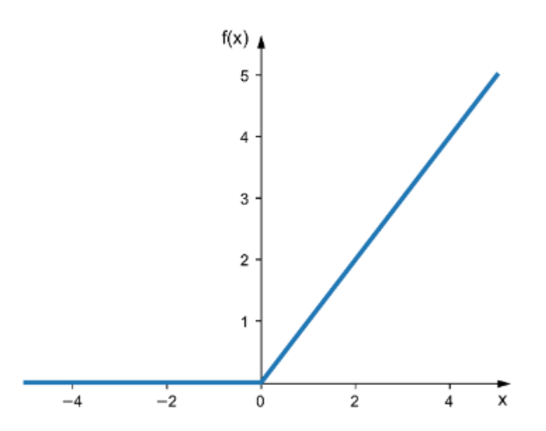


print("Softmax Funcn") 
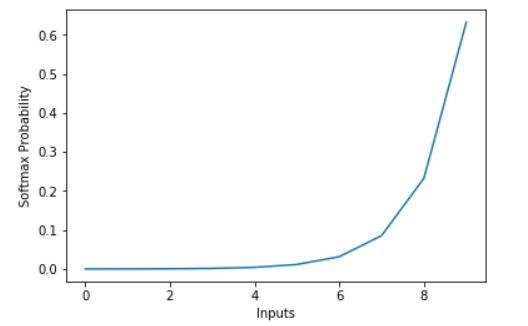

In [ ]:
import cv2
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # converts img as per models requirement (0,1 format or -1,+1)
from tensorflow.keras.preprocessing.image import img_to_array            # Converts a PIL(Python Imaging Library) Image instance to a Numpy array
from tensorflow.keras.models import load_model                           # loads the user trained model 
import numpy as np
import imutils              #  series of convenience functions to make basic image processing
                            #functions such as translation, rotation, resizing, skeletonization, and displaying Matplotlib
import matplotlib.pyplot as plt


def detect_and_predict_helmet(img, faceNet, helmetNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(img, 1.0, (224, 224),  # (images, double scalefactor=1.0, Size , const Scalar &mean=Scalar())
        (104.0, 177.0, 123.0))          #returns a blob which is our input image after mean subtraction, normalizing, and channel swapping

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    print(detections.shape)

    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face Helmet network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = img[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")         # occupies 32 bit memory
        preds = helmetNet.predict(faces, batch_size=32)  

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)   # location(bounding box) and prediction 

# load our serialized face detector model from disk
prototxtPath = r"C:\Users\ASUS\anaconda3\OBJ DETECTION\Helmet Detection\Face-Mask-Detection-master\Face-Mask-Detection-master\face_detector\deploy.prototxt"
weightsPath = r"C:\Users\ASUS\anaconda3\OBJ DETECTION\Helmet Detection\Face-Mask-Detection-master\Face-Mask-Detection-master\face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath) # readnet in deep nural net in cv2 

# load the face helmet detector model from disk
helmetNet = load_model("Helmet_detector.model") # we trained above 

# initialize image
print("[INFO] IMG")
img = cv2.imread(r"D:\Internship\Helmet4.jpg")


while True:
    # detect img and determine if they are wearing a
    # face helmet or not
    (locs, preds) = detect_and_predict_helmet(img, faceNet, helmetNet)

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):    # takes iterable or containers and returns a single iterator object,
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (withHelmet, withoutHelmet) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "With Helmet" if withHelmet > withoutHelmet else "No Helmet"
        color = (0, 255, 0) if label == "Helmet" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(withHelmet, withoutHelmet) * 100) # to display % prediction

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(img, label, (startX, startY - 10),   #text location
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)    #defined font
        cv2.rectangle(img, (startX, startY), (endX, endY), color, 2) 

    # show the output frame
    im1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(im1)
    plt.show()
    #cv2.imshow("helmet", img)
    #key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"): #ord ordinal , a bit mask which sets the left 24 bits to zero, because ord() returns a value betwen 0 and 255
        break

# do a bit of cleanup
cv2.destroyAllWindows()
